In [12]:
import sys 
sys.path.insert(1, "../")
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import ast

import dask.dataframe as dd
from dask.dataframe import from_pandas

from workloads.util import use_results, use_dataset, join_queries_features
from workloads.stl.stl_util import predict, predict_seasonality

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.linear_model import LogisticRegression

In [6]:
experiment = "stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000"
results_dir = use_results(experiment)
dataset_dir = use_dataset(experiment)

/data/wooders/ralf-vldb//datasets/stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000


In [16]:
joined_df = pd.read_csv(f"{results_dir}/query_results_workers_4_lifo_window_672_slide_48.csv")
joined_df["seasonality"] = joined_df['seasonality'].apply(ast.literal_eval)
joined_df["trend"] = joined_df['trend'].apply(ast.literal_eval)
joined_df

,Unnamed: 0,key_id,trend,seasonality,timestamp_ms,processing_time,runtime,ingest_time,timestamp,query_id,query_key_id,query_timestamp
0,0,1,"[196.46980257191117, 178.14672291171956, 160.8...","[50.62005366343661, -23.49503650075765, 93.605...",6540,1.645404e+09,0.106391,1.645404e+09,1.645404e+09,1311,1.0,1.645404e+09
1,1,1,"[196.46980257191117, 178.14672291171956, 160.8...","[50.62005366343661, -23.49503650075765, 93.605...",6540,1.645404e+09,0.106391,1.645404e+09,1.645404e+09,1312,1.0,1.645404e+09
2,2,1,"[196.46980257191117, 178.14672291171956, 160.8...","[50.62005366343661, -23.49503650075765, 93.605...",6540,1.645404e+09,0.106391,1.645404e+09,1.645404e+09,1313,1.0,1.645404e+09
3,3,1,"[196.46980257191117, 178.14672291171956, 160.8...","[50.62005366343661, -23.49503650075765, 93.605...",6540,1.645404e+09,0.106391,1.645404e+09,1.645404e+09,1314,1.0,1.645404e+09
4,4,1,"[196.46980257191117, 178.14672291171956, 160.8...","[50.62005366343661, -23.49503650075765, 93.605...",6540,1.645404e+09,0.106391,1.645404e+09,1.645404e+09,1315,1.0,1.645404e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
62367,62367,100,"[1495.0196515944103, 1504.7833340779011, 1514....","[105.2727994765928, 77.14365803434406, -9.5747...",9155,1.645404e+09,0.099647,1.645404e+09,1.645404e+09,199941,100.0,1.645404e+09
62368,62368,100,"[1495.0196515944103, 1504.7833340779011, 1514....","[105.2727994765928, 77.14365803434406, -9.5747...",9155,1.645404e+09,0.099647,1.645404e+09,1.645404e+09,199942,100.0,1.645404e+09
62369,62369,100,"[1495.0196515944103, 1504.7833340779011, 1514....","[105.2727994765928, 77.14365803434406, -9.5747...",9155,1.645404e+09,0.099647,1.645404e+09,1.645404e+09,199943,100.0,1.645404e+09
62370,62370,100,"[1495.0196515944103, 1504.7833340779011, 1514....","[105.2727994765928, 77.14365803434406, -9.5747...",9155,1.645404e+09,0.099647,1.645404e+09,1.645404e+09,199944,100.0,1.645404e+09


In [17]:
df = queries_df.merge(joined_df, on=["query_id", "key_id"], suffixes=('_query', '_feature'))
joined_df["prediction"] = df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"][-1]), 
        x["seasonality"], 
        int(x["timestamp_ms_query"]), 
        int(x["timestamp_ms_feature"]), 
        interval=5
), axis=1)

In [9]:
timestamp_df = pd.read_csv(f"{results_dir}/results_workers_4_lifo_window_672_slide_48_timestamps.csv")
queries_df = pd.read_csv(f"{dataset_dir}/queries.csv")
queries_df = queries_df.merge(timestamp_df, on="timestamp_ms")

In [7]:
oracle_df = pd.read_csv(f"{dataset_dir}/oracle_features_672.csv").dropna()
oracle_df["seasonality"] = oracle_df['seasonality'].dropna().apply(ast.literal_eval)

In [10]:
oracle_query_df = queries_df.merge(oracle_df, on=["timestamp_ms", "key_id", "value"])

In [13]:
oracle_query_df["prediction"] = oracle_query_df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"]), 
        x["seasonality"], 
        int(x["timestamp_ms"]), 
        int(x["timestamp_ms"]), 
        interval=5
    ), axis=1)
oracle_query_df

,Unnamed: 0_x,key_id,value,timestamp_ms,query_id,timestamp,Unnamed: 0_y,trend,noise,outlier,seasonality,timestamp_ms.1,key_id.1,prediction
0,10671,6,-2031.731179,3355,10671,1.645404e+09,671,-1722.138682,-179.562225,0.0,"[-438.41445878371496, 20.915651101082947, 559....",3355,6,129.414459
1,174671,88,-1352.079809,3355,174671,1.645404e+09,671,-1117.348807,58.546443,0.0,"[-323.39704044739165, -155.26029226523005, 277...",3355,88,88.397040
2,192671,97,1859.207978,3355,192671,1.645404e+09,671,2045.857039,15.302189,0.0,"[-217.73544291946482, 85.50421590502249, 262.7...",3355,97,31.735443
3,86671,44,131.709271,3355,86671,1.645404e+09,671,1111.006064,-65.864757,0.0,"[-748.6440428397661, 177.99368904123864, 465.8...",3355,44,-231.355957
4,136671,69,-272.363200,3355,136671,1.645404e+09,671,5.953501,-11.702695,0.0,"[-267.0470758299926, -64.21271713979031, 378.8...",3355,69,-9.952924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,89945,45,-1674.640299,9725,89945,1.645404e+09,1945,-1321.469837,-219.555949,-497.0,"[-195.8276214365309, 335.44067189843776, 319.8...",9725,45,-157.172379
127496,57945,29,5748.447830,9725,57945,1.645404e+09,1945,5770.600646,93.482390,-450.0,"[75.17668959410672, 1178.82279796637, 1407.315...",9725,29,-97.176690
127497,11945,6,-688.506556,9725,11945,1.645404e+09,1945,-1246.990411,-0.787675,302.0,"[395.8787835202883, 562.9922143905096, 545.626...",9725,6,162.121216
127498,163945,82,0.564617,9725,163945,1.645404e+09,1945,8.738979,2.347922,-41.0,"[60.0959229054298, 122.49133777502146, 142.618...",9725,82,-68.095923


In [18]:
oracle_query_df = oracle_query_df.set_index("query_id")

In [19]:
oracle_query_df

,Unnamed: 0_x,key_id,value,timestamp_ms,timestamp,Unnamed: 0_y,trend,noise,outlier,seasonality,timestamp_ms.1,key_id.1,prediction
query_id,,,,,,,,,,,,,
10671,10671,6,-2031.731179,3355,1.645404e+09,671,-1722.138682,-179.562225,0.0,"[-438.41445878371496, 20.915651101082947, 559....",3355,6,129.414459
174671,174671,88,-1352.079809,3355,1.645404e+09,671,-1117.348807,58.546443,0.0,"[-323.39704044739165, -155.26029226523005, 277...",3355,88,88.397040
192671,192671,97,1859.207978,3355,1.645404e+09,671,2045.857039,15.302189,0.0,"[-217.73544291946482, 85.50421590502249, 262.7...",3355,97,31.735443
86671,86671,44,131.709271,3355,1.645404e+09,671,1111.006064,-65.864757,0.0,"[-748.6440428397661, 177.99368904123864, 465.8...",3355,44,-231.355957
136671,136671,69,-272.363200,3355,1.645404e+09,671,5.953501,-11.702695,0.0,"[-267.0470758299926, -64.21271713979031, 378.8...",3355,69,-9.952924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89945,89945,45,-1674.640299,9725,1.645404e+09,1945,-1321.469837,-219.555949,-497.0,"[-195.8276214365309, 335.44067189843776, 319.8...",9725,45,-157.172379
57945,57945,29,5748.447830,9725,1.645404e+09,1945,5770.600646,93.482390,-450.0,"[75.17668959410672, 1178.82279796637, 1407.315...",9725,29,-97.176690
11945,11945,6,-688.506556,9725,1.645404e+09,1945,-1246.990411,-0.787675,302.0,"[395.8787835202883, 562.9922143905096, 545.626...",9725,6,162.121216


In [22]:
oracle_query_df.loc[10671]["key_id"]

6

In [34]:
# x = [(staleness, key)], # y = [(error)]

ts_limit = 1000*100

X = []
Y = [] 

for key in range(1, 101, 1):
    X.append((0, key))
    Y.append(0)
    
for index, row in joined_df.iterrows():
    staleness = row["query_timestamp"] - row["timestamp"]
    error = oracle_query_df.loc[row["query_id"]]["prediction"] - row["prediction"]
    X.append((staleness, row["key_id"]))
    Y.append(error)
    
    
    
    

0.050075531005859375
0.10577082633972168
0.1704397201538086
0.22620272636413574
0.2814629077911377
0.33527231216430664
0.3892965316772461
0.44350552558898926
0.4980902671813965
0.5554790496826172
0.6087985038757324
0.6579139232635498
0.7055025100708008
0.7563543319702148
0.8071718215942383
0.8580117225646973
0.9155557155609131
0.9688334465026855
1.0231330394744873
1.0744495391845703
1.1263453960418701
1.1814517974853516
1.230541706085205
1.2786214351654053
1.3507835865020752
1.4099407196044922
1.4737937450408936
1.5229816436767578
1.5759682655334473
1.6262245178222656
1.6826269626617432
1.736891746520996
1.7858455181121826
1.8342397212982178
1.8832354545593262
1.9368984699249268
1.9915990829467773
2.0402095317840576
2.0878372192382812
2.1370906829833984
2.1897311210632324
2.2440977096557617
2.296602249145508
2.349492073059082
2.4039056301116943
2.4602465629577637
2.5134265422821045
2.5632801055908203
2.6143863201141357
2.678055763244629
2.733994483947754
2.7846925258636475
2.8442478179

0.7654721736907959
0.8206691741943359
0.8695318698883057
0.9278609752655029
0.9844095706939697
1.0390543937683105
1.091249704360962
1.1473309993743896
1.2058451175689697
1.2538197040557861
1.3061833381652832
1.3611023426055908
1.4164459705352783
1.4670181274414062
1.5157933235168457
1.5717015266418457
1.6282367706298828
1.6783580780029297
1.730593204498291
1.7877354621887207
1.836890697479248
1.8852102756500244
1.9334664344787598
1.9822704792022705
2.0301434993743896
2.0790562629699707
2.127505302429199
2.180387258529663
2.229696273803711
2.2808403968811035
2.3329102993011475
2.3858842849731445
2.4356191158294678
2.4835498332977295
2.531768321990967
2.5842859745025635
2.631971597671509
2.68530535697937
2.736898183822632
2.7887279987335205
2.8349297046661377
2.8809993267059326
2.9286396503448486
2.9786927700042725
3.026508092880249
3.074066400527954
3.1360816955566406
3.1854472160339355
3.2329342365264893
3.280508041381836
0.03508257865905762
0.08593440055847168
0.13675189018249512
0.18

1.8842213153839111
1.9338421821594238
1.998650074005127
2.0551602840423584
2.1070291996002197
2.160006523132324
2.2092998027801514
2.2610793113708496
2.313220977783203
2.3628909587860107
2.4294238090515137
2.4955484867095947
2.546983480453491
2.6033732891082764
2.653784990310669
2.7077829837799072
2.761359453201294
2.81146240234375
2.860196828842163
2.908735990524292
2.96028995513916
3.013490676879883
3.064296007156372
3.1162493228912354
3.166752815246582
3.216364860534668
3.2664794921875
3.3267486095428467
3.3781895637512207
3.43605637550354
3.4847962856292725
3.5339884757995605
3.5826995372772217
3.632979393005371
3.6851208209991455
3.7407431602478027
3.7893290519714355
3.8437530994415283
3.9005467891693115
3.9503419399261475
3.998366594314575
4.046637296676636
4.1041834354400635
4.153181791305542
4.208378791809082
4.257241487503052
4.315570592880249
4.372119188308716
4.426764011383057
4.478959321975708
4.535040616989136
4.593554735183716
4.641529321670532
0.036869049072265625
0.0917

0.2870297431945801
0.34023046493530273
0.391035795211792
0.4429891109466553
0.49349260330200195
0.5431046485900879
0.5932192802429199
0.6534883975982666
0.7049293518066406
0.76279616355896
0.8115360736846924
0.8607282638549805
0.9094393253326416
0.959719181060791
1.0118606090545654
1.0674829483032227
1.1160688400268555
1.1704928874969482
1.2272865772247314
1.2770817279815674
1.3251063823699951
1.3733770847320557
1.4309232234954834
1.479921579360962
1.535118579864502
1.5839812755584717
1.642310380935669
1.6988589763641357
1.7535037994384766
1.805699110031128
1.8617804050445557
1.9202945232391357
1.9682691097259521
2.020632743835449
2.075551748275757
2.1308953762054443
2.1814675331115723
2.2302427291870117
2.2861509323120117
2.342686176300049
2.3928074836730957
2.445042610168457
2.5021848678588867
2.551340103149414
2.5996596813201904
2.647915840148926
2.6967198848724365
2.7445929050445557
2.7935056686401367
2.8419547080993652
2.894836664199829
2.944145679473877
2.9952898025512695
3.04735

2.294485092163086
2.343794107437134
2.3949382305145264
2.4470081329345703
2.4999821186065674
0.035582542419433594
0.08351325988769531
0.13173174858093262
0.1842494010925293
0.2319350242614746
0.28526878356933594
0.33686161041259766
0.38869142532348633
0.4348931312561035
0.48096275329589844
0.5286030769348145
0.5786561965942383
0.6264715194702148
0.6740298271179199
0.7360451221466064
0.7854106426239014
0.8328976631164551
0.8804714679718018
0.046967506408691406
0.11163640022277832
0.16739940643310547
0.22265958786010742
0.27646899223327637
0.3304932117462158
0.384702205657959
0.4392869472503662
0.4966757297515869
0.5499951839447021
0.5991106033325195
0.6466991901397705
0.6975510120391846
0.748368501663208
0.799208402633667
0.8567523956298828
0.9100301265716553
0.964329719543457
1.01564621925354
1.0675420761108398
1.1226484775543213
1.1717383861541748
1.219818115234375
1.291980266571045
1.351137399673462
1.4149904251098633
1.4641783237457275
1.517164945602417
1.5674211978912354
1.62382364

1.8991425037384033
1.9488773345947266
1.9968080520629883
2.0450265407562256
2.0975441932678223
2.1452298164367676
2.198563575744629
2.2501564025878906
2.3019862174987793
2.3481879234313965
2.3942575454711914
2.4418978691101074
2.4919509887695312
2.539766311645508
2.587324619293213
2.6493399143218994
2.6987054347991943
2.746192455291748
2.7937662601470947
0.016623735427856445
0.07846331596374512
0.14676284790039062
0.20122146606445312
0.2529103755950928
0.30633115768432617
0.3601555824279785
0.4161961078643799
0.4693942070007324
0.5215468406677246
0.5701210498809814
0.6206371784210205
0.6756417751312256
0.736250638961792
0.7921974658966064
0.8478927612304688
0.9125616550445557
0.9683246612548828
1.0235848426818848
1.0773942470550537
1.1314184665679932
1.1856274604797363
1.2402122020721436
1.2976009845733643
1.3509204387664795
1.4000358581542969
1.4476244449615479
1.498476266860962
1.5492937564849854
1.6001336574554443
1.6576776504516602
1.7109553813934326
1.7652549743652344
1.8165714740

1.3996033668518066
1.4471771717071533
0.023571014404296875
0.07165074348449707
0.143812894821167
0.20297002792358398
0.26682305335998535
0.3160109519958496
0.36899757385253906
0.4192538261413574
0.47565627098083496
0.5299210548400879
0.5788748264312744
0.6272690296173096
0.676264762878418
0.7299277782440186
0.7846283912658691
0.8332388401031494
0.880866527557373
0.9301199913024902
0.9827604293823242
1.0371270179748535
1.0896315574645996
1.1425213813781738
1.1969349384307861
1.2532758712768555
1.3064558506011963
1.356309413909912
1.4074156284332275
1.4710850715637207
1.5270237922668457
1.5777218341827393
1.6372771263122559
1.690990686416626
0.011749744415283203
0.06069779396057129
0.10901975631713867
0.16245508193969727
0.2136249542236328
0.28126955032348633
0.3482687473297119
0.40103793144226074
0.4561617374420166
0.5062484741210938
0.5598833560943604
0.6125738620758057
0.6632435321807861
0.7141590118408203
0.7690987586975098
0.8268537521362305
0.8756215572357178
0.9371283054351807
0.9

2.877415180206299
2.9267807006835938
0.036629438400268555
0.08420324325561523
0.01117849349975586
0.05961275100708008
0.11437129974365234
0.16527104377746582
0.2202739715576172
0.2693819999694824
0.3257613182067871
0.3876008987426758
0.4559004306793213
0.5103590488433838
0.5620479583740234
0.6154687404632568
0.6692931652069092
0.7253336906433105
0.7785317897796631
0.8306844234466553
0.8792586326599121
0.9297747611999512
0.9847793579101562
1.0453882217407227
1.101335048675537
1.1570303440093994
1.2216992378234863
1.2774622440338135
1.3327224254608154
1.3865318298339844
1.4405560493469238
1.494765043258667
1.5493497848510742
1.606738567352295
1.6600580215454102
1.7091734409332275
1.7567620277404785
1.8076138496398926
1.858431339263916
1.909271240234375
1.9668152332305908
2.0200929641723633
2.074392557144165
2.125709056854248
2.177604913711548
2.2327113151550293
2.281801223754883
2.329880952835083
2.402043104171753
2.46120023727417
2.5250532627105713
2.5742411613464355
2.627227783203125
2

1.1835811138153076
1.241764783859253
1.2949004173278809
0.042494773864746094
0.09743785858154297
0.14661788940429688
0.21062040328979492
0.27423524856567383
0.3379065990447998
0.39046621322631836
0.4422609806060791
0.49173903465270996
0.5453646183013916
0.5977835655212402
0.6492476463317871
0.7043380737304688
0.7557759284973145
0.8091294765472412
0.862074613571167
0.9168999195098877
0.967888593673706
1.0180318355560303
1.0678884983062744
1.1182897090911865
1.1681334972381592
1.2184252738952637
1.2753205299377441
1.3372061252593994
1.3867502212524414
1.4391894340515137
1.4963295459747314
1.549863338470459
1.5996053218841553
1.6478848457336426
1.6957690715789795
1.7467503547668457
1.8025219440460205
1.8513774871826172
1.9049608707427979
1.9547433853149414
2.0074381828308105
2.061391592025757
2.1145882606506348
2.164637565612793
2.215195417404175
2.272507905960083
2.3232624530792236
2.3709299564361572
2.419112205505371
2.4692068099975586
2.5194084644317627
2.566401720046997
2.614296197891

1.0892443656921387
1.1414666175842285
1.190558671951294
1.241133213043213
1.2971866130828857
1.3495147228240967
1.3982791900634766
1.4557716846466064
1.508542776107788
1.5592176914215088
1.6098690032958984
1.6631948947906494
1.7139208316802979
1.7679188251495361
1.818159818649292
1.8700828552246094
1.9216790199279785
1.9725852012634277
2.024293899536133
2.0855817794799805
2.1429429054260254
2.1940369606018066
2.2409372329711914
2.290353298187256
2.339390754699707
2.3947665691375732
2.444136381149292
2.4957618713378906
2.546391487121582
2.607351541519165
2.6632933616638184
2.719432830810547
2.7788383960723877
2.8303918838500977
2.886545181274414
2.9458467960357666
3.001542568206787
3.056718587875366
3.108365297317505
3.1589977741241455
3.2091808319091797
3.257840394973755
3.3261685371398926
3.39084792137146
3.456367015838623
3.516435384750366
3.5660858154296875
3.614297389984131
3.6618595123291016
3.7091095447540283
3.7567293643951416
3.8050572872161865
3.8528616428375244
3.900694608688

2.5103940963745117
2.5622925758361816
2.6112115383148193
2.662529468536377
2.7126402854919434
2.7616806030273438
2.809330701828003
2.8567698001861572
2.9130735397338867
2.962360143661499
3.014552354812622
3.0646355152130127
3.1126012802124023
3.161365509033203
3.2100510597229004
0.020000696182250977
0.0698246955871582
0.11917376518249512
0.1675105094909668
0.21555304527282715
0.26501011848449707
0.3139052391052246
0.3627629280090332
0.4124114513397217
0.4632229804992676
0.5174076557159424
0.5703604221343994
0.6190781593322754
0.6713192462921143
0.729736328125
0.786888599395752
0.8425412178039551
0.896895170211792
0.9482555389404297
0.9950811862945557
1.0471322536468506
1.0981378555297852
1.1464321613311768
1.1961300373077393
1.24772310256958
1.2995760440826416
1.350539207458496
1.4002504348754883
1.4563536643981934
1.5044126510620117
1.5533523559570312
1.600400686264038
1.6530051231384277
1.7064085006713867
1.7535655498504639
1.8122024536132812
1.865340232849121
1.9161632061004639
1.96

1.3588061332702637
1.4076688289642334
1.4659979343414307
1.5225465297698975
1.5771913528442383
1.6293866634368896
1.6854679584503174
1.7439820766448975
1.7919566631317139
1.844320297241211
1.8992393016815186
1.954582929611206
2.005155086517334
2.0539302825927734
2.1098384857177734
2.1663737297058105
2.2164950370788574
2.2687301635742188
2.3258724212646484
2.375027656555176
2.423347234725952
2.4716033935546875
2.5204074382781982
2.5682804584503174
2.6171932220458984
2.665642261505127
2.718524217605591
2.7678332328796387
2.8189773559570312
2.871047258377075
2.9240212440490723
2.9737560749053955
3.0216867923736572
3.0699052810668945
3.122422933578491
3.1701085567474365
3.223442316055298
3.2750351428985596
3.3268649578094482
3.3730666637420654
3.4191362857818604
3.4667766094207764
0.042704105377197266
0.09051942825317383
0.1380777359008789
0.20009303092956543
0.24945855140686035
0.29694557189941406
0.34451937675476074
0.004803180694580078
0.056955814361572266
0.1055300235748291
0.156046152

3.6464245319366455
3.7140769958496094
3.7716147899627686
3.8197243213653564
3.877232074737549
3.9262008666992188
3.9739391803741455
4.021841764450073
4.0747480392456055
4.124544620513916
4.173233985900879
4.22187876701355
0.02662515640258789
0.07453370094299316
0.12253379821777344
0.1703195571899414
0.21755623817443848
0.26539087295532227
0.3143911361694336
0.3665480613708496
0.4206051826477051
0.47291994094848633
0.5215494632720947
0.5711703300476074
0.6359782218933105
0.692488431930542
0.7443573474884033
0.7973346710205078
0.846627950668335
0.8984074592590332
0.9505491256713867
1.0002191066741943
1.0667519569396973
1.1328766345977783
1.1843116283416748
1.24070143699646
1.2911131381988525
1.3451111316680908
1.3986876010894775
1.4487905502319336
1.4975249767303467
1.5460641384124756
1.5976181030273438
1.6508188247680664
1.7016241550445557
1.753577470779419
1.8040809631347656
1.8536930084228516
1.9038076400756836
1.9640767574310303
2.0155177116394043
2.0733845233917236
2.122124433517456

3.7730867862701416
3.8210041522979736
3.872002601623535
3.922372341156006
3.9722907543182373
4.023812770843506
4.076811790466309
4.12797999382019
4.179530382156372
4.24278450012207
4.30394172668457
4.3717896938323975
4.420862436294556
4.467970609664917
4.523242473602295
4.580329179763794
4.633393049240112
0.04467320442199707
0.0956578254699707
0.14491486549377441
0.1962599754333496
0.2485339641571045
0.3110690116882324
0.3649332523345947
0.42996931076049805
0.47963547706604004
0.5317223072052002
0.5822110176086426
0.6413037776947021
0.690528154373169
0.739128828048706
0.7952160835266113
0.8602738380432129
0.017075300216674805
0.07049560546875
0.11954641342163086
0.17140865325927734
0.22585296630859375
0.274829626083374
0.32720422744750977
0.37818241119384766
0.4279947280883789
0.484813928604126
0.5338988304138184
0.5810501575469971
0.6280944347381592
0.6749956607818604
0.727323055267334
0.7795577049255371
0.8331506252288818
0.8872730731964111
0.9423675537109375
0.9980337619781494
1.055

2.836897611618042
2.8875815868377686
2.9380035400390625
2.9859814643859863
3.037548542022705
3.1018447875976562
3.151607036590576
3.203511953353882
3.253765344619751
3.3045101165771484
3.353353977203369
3.4023218154907227
3.456225633621216
3.5055325031280518
3.5545856952667236
3.603414535522461
3.651578903198242
3.699143648147583
3.7465734481811523
3.7939157485961914
3.8416967391967773
3.889951705932617
3.946145534515381
3.995918035507202
4.05216121673584
4.100515604019165
4.148083925247192
4.196376323699951
4.242861032485962
4.290700197219849
4.339312791824341
4.38637113571167
4.4343602657318115
4.4831390380859375
4.532575845718384
4.584283828735352
4.632376670837402
4.687988996505737
4.74017071723938
4.793553352355957
4.8469765186309814
4.899433612823486
4.946507453918457
4.993304014205933
5.041638612747192
5.090973138809204
5.1399149894714355
5.188413858413696
5.236212491989136
5.290696620941162
0.0305025577545166
0.0914609432220459
0.14684176445007324
0.2015218734741211
0.252527713

0.043538570404052734
0.09273076057434082
0.14144182205200195
0.19172167778015137
0.24386310577392578
0.299485445022583
0.3480713367462158
0.4024953842163086
0.4592890739440918
0.5090842247009277
0.5571088790893555
0.605379581451416
0.6629257202148438
0.7119240760803223
0.7671210765838623
0.815983772277832
0.8743128776550293
0.9308614730834961
0.9855062961578369
1.0377016067504883
1.093782901763916
1.152297019958496
1.2002716064453125
1.2526352405548096
1.3075542449951172
1.3628978729248047
1.4134700298309326
1.462245225906372
1.518153429031372
1.5746886730194092
1.624809980392456
1.6770451068878174
1.734187364578247
1.7833425998687744
1.8316621780395508
1.8799183368682861
1.9287223815917969
1.976595401763916
2.025508165359497
2.0739572048187256
2.1268391609191895
2.1761481761932373
2.22729229927063
2.279362201690674
2.332336187362671
2.382071018218994
2.430001735687256
2.478220224380493
2.53073787689209
2.578423500061035
2.6317572593688965
2.683350086212158
2.735179901123047
2.78138160

1.2673232555389404
1.3202130794525146
1.374626636505127
1.4309675693511963
1.484147548675537
1.534001111984253
1.5851073265075684
1.6487767696380615
1.7047154903411865
1.75541353225708
1.8149688243865967
1.8686823844909668
1.9145467281341553
1.9634947776794434
2.0118167400360107
2.0652520656585693
2.116421937942505
2.1840665340423584
2.251065731048584
2.303834915161133
0.0181119441986084
0.06819868087768555
0.12183356285095215
0.17452406883239746
0.22519373893737793
0.2761092185974121
0.33104896545410156
0.38880395889282227
0.43757176399230957
0.49907851219177246
0.547339677810669
0.594294548034668
0.6437597274780273
0.6945891380310059
0.7550458908081055
0.804673433303833
0.8583366870880127
0.9112296104431152
0.9633183479309082
1.011458158493042
1.0639779567718506
1.1180379390716553
1.1718659400939941
1.2250251770019531
1.27357816696167
1.3256397247314453
1.3797600269317627
1.4319162368774414
1.481332778930664
1.5426723957061768
1.5942935943603516
1.6459226608276367
1.6960818767547607


1.1289656162261963
1.180673599243164
1.2287664413452148
1.2843787670135498
1.3365604877471924
1.3899431228637695
1.443366289138794
1.4958233833312988
1.5428972244262695
1.5896937847137451
1.6380283832550049
1.6873629093170166
1.736304759979248
1.7848036289215088
1.8326022624969482
1.8870863914489746
1.9493906497955322
2.0103490352630615
2.065729856491089
2.1204099655151367
2.1714158058166504
2.220855474472046
2.2709062099456787
2.328531265258789
2.3860275745391846
2.434497356414795
2.4825639724731445
2.5302252769470215
2.5785725116729736
2.627166509628296
2.6750731468200684
2.732789993286133
2.7845618724823
2.8319296836853027
2.8803794384002686
2.933002233505249
0.01802682876586914
0.07455658912658691
0.12908363342285156
0.17934298515319824
0.23732590675354004
0.29583096504211426
0.3483443260192871
0.40343165397644043
0.4592316150665283
0.51127028465271
0.564415454864502
0.6146907806396484
0.6730759143829346
0.724297046661377
0.7762548923492432
0.8247973918914795
0.8836917877197266
0.9

1.957237958908081
2.011141777038574
2.06044864654541
2.109501838684082
2.1583306789398193
2.2064950466156006
2.2540597915649414
2.3014895915985107
2.34883189201355
2.3966128826141357
2.4448678493499756
2.5010616779327393
2.5508341789245605
2.6070773601531982
2.6554317474365234
2.703000068664551
0.03785204887390137
0.08433675765991211
0.13217592239379883
0.18078851699829102
0.22784686088562012
0.2758359909057617
0.3246147632598877
0.374051570892334
0.42575955390930176
0.47385239601135254
0.5294647216796875
0.5816464424133301
0.6350290775299072
0.6884522438049316
0.7409093379974365
0.7879831790924072
0.8347797393798828
0.8831143379211426
0.9324488639831543
0.9813907146453857
1.0298895835876465
1.077688217163086
1.1321723461151123
1.19447660446167
1.2554349899291992
1.3108158111572266
1.3654959201812744
1.416501760482788
1.4659414291381836
1.5159921646118164
1.5736172199249268
1.6311135292053223
1.6795833110809326
1.7276499271392822
1.7753112316131592
1.8236584663391113
1.8722524642944336

0.6487946510314941
0.6997578144073486
0.7494690418243408
0.8055722713470459
0.8536312580108643
0.9025709629058838
0.9496192932128906
1.0022237300872803
1.0556271076202393
1.1027841567993164
0.0372004508972168
0.09033823013305664
0.14116120338439941
0.18912172317504883
0.23722600936889648
0.28464388847351074
0.3348524570465088
0.3843820095062256
0.4376554489135742
0.48624491691589355
0.5356204509735107
0.5909905433654785
0.6459548473358154
0.6942551136016846
0.7490520477294922
0.7966530323028564
0.8446412086486816
0.8914451599121094
0.9391906261444092
0.990297794342041
1.051008939743042
1.1044211387634277
1.156327247619629
1.2128312587738037
1.2672786712646484
1.3155691623687744
1.3639605045318604
1.4151177406311035
1.4640097618103027
1.5132389068603516
1.5624680519104004
1.610863447189331
1.66347074508667
1.7203881740570068
1.7730133533477783
1.8240430355072021
1.8734889030456543
1.9237375259399414
1.975672960281372
2.0262956619262695
2.0842087268829346
2.134892702102661
2.185314655303

0.5376358032226562
0.5881245136260986
0.6472172737121582
0.696441650390625
0.7450423240661621
0.8011295795440674
0.866187334060669
0.9344689846038818
0.987889289855957
1.036940097808838
1.0888023376464844
1.1432466506958008
1.192223310470581
1.2445979118347168
1.2955760955810547
1.345388412475586
1.402207612991333
1.4512925148010254
1.498443841934204
1.5454881191253662
1.5923893451690674
1.644716739654541
1.6969513893127441
1.7505443096160889
1.8046667575836182
1.8597612380981445
1.9154274463653564
1.9724063873291016
2.0287935733795166
2.0828018188476562
2.133064031600952
2.1849095821380615
2.240584373474121
2.294856309890747
2.347107410430908
2.394960641860962
2.4422767162323
2.4946463108062744
2.5460238456726074
2.5974795818328857
2.6490893363952637
2.6996982097625732
2.759780168533325
2.8119869232177734
2.860733985900879
2.9124581813812256
2.963669776916504
3.013371229171753
3.062488317489624
0.006877899169921875
0.05673646926879883
0.10512971878051758
0.15387201309204102
0.21271777

3.581794023513794
3.6343536376953125
3.6861484050750732
3.735626459121704
3.7892520427703857
3.8416709899902344
3.8931350708007812
3.948225498199463
3.9996633529663086
4.053016901016235
4.105962038040161
4.160787343978882
4.2117760181427
4.261919260025024
4.3117759227752686
4.362177133560181
4.412020921707153
4.462312698364258
4.519207954406738
4.5810935497283936
4.6306376457214355
4.683076858520508
4.740216970443726
4.793750762939453
4.843492746353149
4.891772270202637
0.011234045028686523
0.062215328216552734
0.11798691749572754
0.16684246063232422
0.22042584419250488
0.27020835876464844
0.3229031562805176
0.37685656547546387
0.4300532341003418
0.4801025390625
0.5306603908538818
0.58797287940979
0.6387274265289307
0.6863949298858643
0.7345771789550781
0.7846717834472656
0.8348734378814697
0.01311182975769043
0.06100630760192871
0.10916948318481445
0.1583399772644043
0.21056222915649414
0.25965428352355957
0.3102288246154785
0.36628222465515137
0.4186103343963623
0.4673748016357422
0.

1.391075611114502
1.4472150802612305
1.5066206455230713
1.5581741333007812
1.6143274307250977
1.6736290454864502
1.7293248176574707
1.7845008373260498
1.8361475467681885
1.886780023574829
1.9369630813598633
1.9856226444244385
2.053950786590576
2.1186301708221436
2.1841492652893066
2.24421763420105
2.293868064880371
2.3420796394348145
2.389641761779785
2.436891794204712
2.484511613845825
2.53283953666687
2.580643892288208
2.628476858139038
2.681004047393799
2.7286789417266846
2.777560234069824
2.831524610519409
2.8959226608276367
2.95233154296875
3.0004730224609375
3.0527517795562744
3.102163791656494
3.150660753250122
3.1987786293029785
3.2464559078216553
3.310397148132324
3.362285614013672
3.409771203994751
3.4573657512664795
3.504772663116455
3.553095817565918
3.608839750289917
3.6627442836761475
3.7217304706573486
0.014925241470336914
0.06600594520568848
0.1148531436920166
0.16539788246154785
0.21944952011108398
0.27031779289245605
0.32245922088623047
0.37064266204833984
0.418257236

0.7951610088348389
0.8563182353973389
0.924166202545166
0.9732389450073242
1.0203471183776855
1.0756189823150635
1.1327056884765625
1.1857695579528809
1.2360684871673584
1.287053108215332
1.3363101482391357
1.387655258178711
1.4399292469024658
1.5024642944335938
1.556328535079956
1.6213645935058594
1.6710307598114014
1.7231175899505615
1.773606300354004
1.8326990604400635
1.8819234371185303
1.9305241107940674
1.9866113662719727
2.051669120788574
2.119950771331787
2.1733710765838623
2.222421884536743
2.2742841243743896
2.328728437423706
2.3777050971984863
2.430079698562622
2.48105788230896
2.530870199203491
2.5876893997192383
2.6367743015289307
2.6839256286621094
2.7309699058532715
2.7778711318969727
2.8301985263824463
2.8824331760406494
2.936026096343994
2.9901485443115234
3.04524302482605
3.1009092330932617
3.157888174057007
3.214275360107422
3.2682836055755615
3.3185458183288574
3.370391368865967
3.4260661602020264
0.04990839958190918
0.10215950012207031
0.15001273155212402
0.1973288

0.9819490909576416
1.0345895290374756
1.0889561176300049
1.141460657119751
1.1943504810333252
1.2487640380859375
1.3051049709320068
1.3582849502563477
1.4081385135650635
1.459244728088379
1.522914171218872
1.578852891921997
1.6295509338378906
1.6891062259674072
1.7428197860717773
1.7886841297149658
1.837632179260254
1.8859541416168213
1.9393894672393799
1.9905593395233154
2.058203935623169
0.027698993682861328
0.08046817779541016
0.13559198379516602
0.18567872047424316
0.23931360244750977
0.2920041084289551
0.34267377853393555
0.3935892581939697
0.4485290050506592
0.5062839984893799
0.5550518035888672
0.6165585517883301
0.6648197174072266
0.7117745876312256
0.761239767074585
0.8120691776275635
0.8725259304046631
0.9221534729003906
0.9758167266845703
1.0287096500396729
1.0807983875274658
1.1289381980895996
1.1814579963684082
1.235517978668213
1.2893459796905518
1.3425052165985107
1.3910582065582275
1.443119764328003
1.4972400665283203
1.549396276473999
1.5988128185272217
1.6601524353027

1.4093260765075684
1.459737777709961
1.5137357711791992
1.567312240600586
1.617415189743042
1.666149616241455
1.714688777923584
1.7662427425384521
1.8194434642791748
1.870248794555664
1.9222021102905273
1.972705602645874
2.02231764793396
2.072432279586792
2.1327013969421387
2.1841423511505127
2.242009162902832
2.2907490730285645
2.3399412631988525
2.3886523246765137
2.438932180404663
2.4910736083984375
2.5466959476470947
2.5952818393707275
2.6497058868408203
2.7064995765686035
2.7562947273254395
2.804319381713867
2.8525900840759277
2.9101362228393555
2.959134578704834
3.014331579208374
3.0631942749023438
3.121523380279541
3.178071975708008
3.2327167987823486
3.284912109375
3.3409934043884277
3.399507522583008
3.447482109069824
3.4998457431793213
3.554764747619629
3.6101083755493164
3.6606805324554443
3.709455728530884
0.02800893783569336
0.08454418182373047
0.13466548919677734
0.18690061569213867
0.24404287338256836
0.2931981086730957
0.34151768684387207
0.3897738456726074
0.4385778903

1.7169969081878662
1.7737905979156494
1.8235857486724854
1.871610403060913
1.9198811054229736
0.044405221939086914
0.09340357780456543
0.14860057830810547
0.1974632740020752
0.25579237937927246
0.31234097480773926
0.3669857978820801
0.41918110847473145
0.4752624034881592
0.5337765216827393
0.5817511081695557
0.6341147422790527
0.6890337467193604
0.7443773746490479
0.7949495315551758
0.8437247276306152
0.8996329307556152
0.9561681747436523
1.0062894821166992
1.0585246086120605
1.1156668663024902
1.1648221015930176
1.213141679763794
1.2613978385925293
1.31020188331604
1.3580749034881592
1.4069876670837402
1.4554367065429688
1.5083186626434326
1.5576276779174805
1.608771800994873
1.660841703414917
1.713815689086914
1.7635505199432373
1.811481237411499
1.8596997261047363
1.912217378616333
1.9599030017852783
2.0132367610931396
2.0648295879364014
2.11665940284729
2.1628611087799072
2.208930730819702
2.256571054458618
2.306624174118042
2.3544394969940186
2.4019978046417236
2.46401309967041
2.

1.4942476749420166
1.5474069118499756
1.5959599018096924
1.6480214595794678
1.7021417617797852
1.7542979717254639
1.8037145137786865
1.8650541305541992
1.916675329208374
1.9683043956756592
2.018463611602783
2.0865044593811035
2.1501998901367188
2.202934741973877
2.2577247619628906
2.3108222484588623
2.364323139190674
2.428568124771118
2.482645273208618
2.536907196044922
2.5979790687561035
2.653247594833374
2.7072455883026123
2.764416217803955
2.8222298622131348
2.879817008972168
2.9380006790161133
2.991136312484741
3.046189069747925
3.1011321544647217
3.1503121852874756
3.2143146991729736
3.2779295444488525
3.3416008949279785
3.394160509109497
3.445955276489258
3.4954333305358887
3.5490589141845703
3.601477861404419
3.652941942214966
3.7080323696136475
3.759470224380493
0.013976335525512695
0.06692147254943848
0.12174677848815918
0.17273545265197754
0.22287869453430176
0.2727353572845459
0.323136568069458
0.37298035621643066
0.42327213287353516
0.4801673889160156
0.5420529842376709
0.5

1.1362287998199463
1.197568416595459
1.2491896152496338
1.300818681716919
1.350977897644043
1.4190187454223633
0.0410304069519043
0.0937652587890625
0.14855527877807617
0.20165276527404785
0.2551536560058594
0.3193986415863037
0.3734757900238037
0.4277377128601074
0.48880958557128906
0.5440781116485596
0.5980761051177979
0.6552467346191406
0.7130603790283203
0.7706475257873535
0.8288311958312988
0.8819668292999268
0.9370195865631104
0.9919626712799072
1.0411427021026611
1.1051452159881592
1.168760061264038
1.232431411743164
1.2849910259246826
1.3367857933044434
1.3862638473510742
1.4398894309997559
1.4923083782196045
1.5437724590301514
1.598862886428833
1.6503007411956787
1.7036542892456055
1.7565994262695312
1.811424732208252
1.8624134063720703
1.9125566482543945
1.9624133110046387
2.012814521789551
2.0626583099365234
2.112950086593628
2.1698453426361084
2.2317309379577637
2.2812750339508057
2.333714246749878
2.3908543586730957
2.4443881511688232
2.4941301345825195
2.542409658432007
2

0.22898554801940918
0.2806110382080078
0.3312406539916992
0.3922007083892822
0.44814252853393555
0.5042819976806641
0.5636875629425049
0.6152410507202148
0.6713943481445312
0.7306959629058838
0.7863917350769043
0.8415677547454834
0.8932144641876221
0.9438469409942627
0.03208613395690918
0.08074569702148438
0.14907383918762207
0.21375322341918945
0.27927231788635254
0.3393406867980957
0.388991117477417
0.43720269203186035
0.48476481437683105
0.5320148468017578
0.5796346664428711
0.627962589263916
0.6757669448852539
0.723599910736084
0.7761270999908447
0.8238019943237305
0.8726832866668701
0.9266476631164551
0.9910457134246826
1.047454595565796
1.0955960750579834
1.1478748321533203
1.19728684425354
1.245783805847168
1.2939016819000244
1.3415789604187012
1.4055202007293701
1.4574086666107178
1.5048942565917969
1.5524888038635254
1.599895715713501
1.6482188701629639
1.703962802886963
1.7578673362731934
1.8168535232543945
1.8675999641418457
1.9186806678771973
1.9675278663635254
2.0180726051

1.1165330410003662
1.165762186050415
1.2149913311004639
1.2633867263793945
1.3159940242767334
1.3729114532470703
1.4255366325378418
1.4765663146972656
1.5260121822357178
1.5762608051300049
1.6281962394714355
1.678818941116333
1.736732006072998
1.7874159812927246
1.8378379344940186
1.8858158588409424
1.9373829364776611
2.0016791820526123
2.0514414310455322
2.103346347808838
2.153599739074707
2.2043445110321045
2.253188371658325
2.3021562099456787
2.356060028076172
2.405366897583008
2.4544200897216797
2.503248929977417
2.5514132976531982
2.598978042602539
2.6464078426361084
2.6937501430511475
2.7415311336517334
2.7897861003875732
2.845979928970337
2.895752429962158
2.951995611190796
3.000349998474121
3.0479183197021484
3.0962107181549072
3.142695426940918
3.1905345916748047
3.239147186279297
3.286205530166626
3.3341946601867676
3.3829734325408936
3.43241024017334
3.4841182231903076
3.5322110652923584
3.5878233909606934
3.640005111694336
3.693387746810913
3.7468109130859375
3.799268007278

0.07674741744995117
0.12826943397521973
0.18126845359802246
0.2324366569519043
0.28398704528808594
0.3472411632537842
0.4083983898162842
0.47624635696411133
0.5253190994262695
0.5724272727966309
0.6276991367340088
0.6847858428955078
0.7378497123718262
0.7881486415863037
0.8391332626342773
0.888390302658081
0.9397354125976562
0.9920094013214111
1.054544448852539
1.1084086894989014
1.1734447479248047
1.2231109142303467
1.2751977443695068
1.3256864547729492
1.3847792148590088
1.4340035915374756
1.4826042652130127
1.538691520690918
1.6037492752075195
1.6720309257507324
1.7254512310028076
1.7745020389556885
1.826364278793335
1.8808085918426514
1.9297852516174316
1.9821598529815674
2.0331380367279053
2.0829503536224365
2.1397695541381836
2.188854455947876
2.2360057830810547
2.283050060272217
2.329951286315918
2.3822786808013916
2.4345133304595947
2.4881062507629395
2.5422286987304688
0.04471993446350098
0.10038614273071289
0.157365083694458
0.21375226974487305
0.2677605152130127
0.3180227279

2.3520009517669678
2.4003942012786865
2.44913649559021
2.5079822540283203
2.575634717941284
2.6331725120544434
2.6812820434570312
2.7387897968292236
2.7877585887908936
2.8354969024658203
2.883399486541748
2.9363057613372803
2.986102342605591
3.0347917079925537
3.0834364891052246
3.132472515106201
3.1803810596466064
3.2283811569213867
3.2761669158935547
3.3234035968780518
3.3712382316589355
3.420238494873047
3.472395420074463
3.5264525413513184
3.5787672996520996
3.627396821975708
3.6770176887512207
3.741825580596924
3.7983357906341553
3.8502047061920166
3.903182029724121
3.9524753093719482
4.0042548179626465
4.056396484375
4.106066465377808
4.1725993156433105
4.238723993301392
4.290158987045288
0.031992435455322266
0.08240413665771484
0.13640213012695312
0.18997859954833984
0.2400815486907959
0.288815975189209
0.3373551368713379
0.38890910148620605
0.4421098232269287
0.49291515350341797
0.5448684692382812
0.5953719615936279
0.6449840068817139
0.6950986385345459
0.7553677558898926
0.806

2.885646343231201
2.9353811740875244
2.983311891555786
3.0315303802490234
3.08404803276062
3.1317336559295654
3.1850674152374268
3.2366602420806885
3.288490056991577
3.3346917629241943
3.3807613849639893
3.4284017086029053
3.478454828262329
3.5262701511383057
3.5738284587860107
3.6358437538146973
3.685209274291992
3.732696294784546
3.7802700996398926
0.04691791534423828
0.09591364860534668
0.14957666397094727
0.20427727699279785
0.2528877258300781
0.30051541328430176
0.34976887702941895
0.40240931510925293
0.4567759037017822
0.5092804431915283
0.5621702671051025
0.6165838241577148
0.0340876579284668
0.08726763725280762
0.13712120056152344
0.18822741508483887
0.25189685821533203
0.30783557891845703
0.3585336208343506
0.4180889129638672
0.4718024730682373
0.5176668167114258
0.5666148662567139
0.6149368286132812
0.6683721542358398
0.7195420265197754
0.7871866226196289
0.8541858196258545
0.9069550037384033
0.9620788097381592
1.0121655464172363
1.065800428390503
1.1184909343719482
1.1691606

0.1395556926727295
0.1907672882080078
0.24046874046325684
0.28958582878112793
0.3415029048919678
0.3913614749908447
0.4397547245025635
0.4884970188140869
0.5473427772521973
0.6149952411651611
0.6725330352783203
0.7206425666809082
0.7781503200531006
0.8271191120147705
0.8748574256896973
0.922760009765625
0.9756662845611572
1.0254628658294678
1.0741522312164307
1.1227970123291016
1.1718330383300781
1.2197415828704834
1.2677416801452637
1.3155274391174316
1.3627641201019287
1.4105987548828125
1.4595990180969238
1.5117559432983398
1.5658130645751953
1.6181278228759766
1.666757345199585
1.7163782119750977
1.7811861038208008
1.8376963138580322
1.8895652294158936
1.942542552947998
1.9918358325958252
2.0436153411865234
2.095757007598877
2.1454269886016846
2.2119598388671875
2.2780845165252686
2.329519510269165
2.38590931892395
2.4363210201263428
2.490319013595581
2.5438954830169678
2.593998432159424
2.642732858657837
2.691272020339966
2.742825984954834
2.7960267066955566
2.846832036972046
2.89

0.26355528831481934
0.31741952896118164
0.38245558738708496
0.02486133575439453
0.07694816589355469
0.12743687629699707
0.18652963638305664
0.23575401306152344
0.28435468673706055
0.3404419422149658
0.4054996967315674
0.4737813472747803
0.5272016525268555
0.5762524604797363
0.6281147003173828
0.6825590133666992
0.7315356731414795
0.7839102745056152
0.8348884582519531
0.8847007751464844
0.9415199756622314
0.9906048774719238
1.0377562046051025
1.0848004817962646
1.1317017078399658
1.1840291023254395
1.2362637519836426
1.2898566722869873
1.3439791202545166
1.399073600769043
1.4547398090362549
1.51171875
1.568105936050415
1.6221141815185547
1.6723763942718506
1.72422194480896
1.7798967361450195
1.8341686725616455
1.8864197731018066
1.9342730045318604
1.9815890789031982
2.033958673477173
2.085336208343506
2.136791944503784
2.188401699066162
2.2390105724334717
2.2990925312042236
2.351299285888672
2.4000463485717773
2.451770544052124
2.5029821395874023
2.5526835918426514
2.6018006801605225
2.

0.463306188583374
0.5127713680267334
0.5636007785797119
0.6240575313568115
0.6736850738525391
0.7273483276367188
0.7802412509918213
0.8323299884796143
0.880469799041748
0.9329895973205566
0.9870495796203613
1.0408775806427002
1.0940368175506592
1.142589807510376
1.1946513652801514
1.2487716674804688
1.3009278774261475
1.3503444194793701
1.4116840362548828
1.4633052349090576
1.5149343013763428
1.5650935173034668
1.633134365081787
1.6968297958374023
1.7495646476745605
1.8043546676635742
1.857452154159546
1.9109530448913574
1.9751980304718018
2.0292751789093018
2.0835371017456055
2.144608974456787
2.1998775005340576
2.253875494003296
2.3110461235046387
2.3688597679138184
2.4264469146728516
2.484630584716797
2.537766218185425
2.5928189754486084
2.6477620601654053
2.696942090988159
2.7609446048736572
2.824559450149536
2.888230800628662
2.9407904148101807
2.9925851821899414
3.0420632362365723
3.095688819885254
3.1481077671051025
3.1995718479156494
3.254662275314331
3.3061001300811768
3.35945

2.3425133228302
2.3914260864257812
2.4398751258850098
2.4927570819854736
2.5420660972595215
2.593210220336914
2.645280122756958
2.698254108428955
2.7479889392852783
2.79591965675354
2.8441381454467773
2.896655797958374
2.9443414211273193
2.9976751804351807
3.0492680072784424
3.101097822189331
3.1472995281219482
3.193369150161743
3.241009473800659
3.291062593460083
3.3388779163360596
3.3864362239837646
3.448451519012451
3.497817039489746
3.5453040599823
3.5928778648376465
0.02953815460205078
0.08122706413269043
0.13464784622192383
0.18847227096557617
0.24451279640197754
0.2977108955383301
0.34986352920532227
0.3984377384185791
0.44895386695861816
0.5039584636688232
0.5645673274993896
0.6205141544342041
0.6762094497680664
0.7408783435821533
0.7966413497924805
0.8519015312194824
0.9057109355926514
0.9597351551055908
1.013944149017334
1.0685288906097412
1.125917673110962
1.1792371273040771
1.2283525466918945
1.2759411334991455
1.3267929553985596
1.377610445022583
1.428450345993042
1.485994

1.8276917934417725
1.8802051544189453
1.9352924823760986
1.9910924434661865
2.043131113052368
2.09627628326416
2.1465516090393066
2.2049367427825928
2.256157875061035
2.3081157207489014
2.3566582202911377
2.4155526161193848
2.469219207763672
2.517136573791504
2.5681350231170654
0.04979348182678223
0.09971189498901367
0.15123391151428223
0.20423293113708496
0.2554011344909668
0.30695152282714844
0.3702056407928467
0.4313628673553467
0.49921083450317383
0.548283576965332
0.5953917503356934
0.6506636142730713
0.7077503204345703
0.7608141899108887
0.8111131191253662
0.8620977401733398
0.9113547801971436
0.9626998901367188
1.0149738788604736
1.0775089263916016
1.1313731670379639
1.1964092254638672
1.2460753917694092
1.2981622219085693
1.3486509323120117
1.4077436923980713
1.456968069076538
1.5055687427520752
1.5616559982299805
1.626713752746582
1.694995403289795
1.7484157085418701
0.0030057430267333984
0.05486798286437988
0.10931229591369629
0.15828895568847656
0.2106635570526123
0.26164174

1.8549253940582275
1.9113152027130127
1.9617269039154053
2.0157248973846436
2.0693013668060303
2.1194043159484863
2.1681387424468994
2.2166779041290283
2.2682318687438965
2.321432590484619
2.3722379207611084
2.4241912364959717
2.4746947288513184
2.5243067741394043
2.5744214057922363
2.634690523147583
2.686131477355957
2.7439982891082764
2.792738199234009
2.841930389404297
2.890641450881958
2.9409213066101074
2.993062734603882
3.048685073852539
3.097270965576172
3.1516950130462646
3.208488702774048
3.258283853530884
3.3063085079193115
3.354579210281372
3.4121253490448
3.4611237049102783
3.5163207054138184
3.565183401107788
3.6235125064849854
3.680061101913452
3.734705924987793
3.7869012355804443
3.842982530593872
3.901496648788452
3.9494712352752686
4.001834869384766
4.056753873825073
4.112097501754761
4.162669658660889
4.211444854736328
4.267353057861328
4.323888301849365
4.374009609222412
4.426244735717773
4.483386993408203
4.5325422286987305
0.01302337646484375
0.0612795352935791
0.1

2.254659414291382
2.3159990310668945
2.3676202297210693
2.4192492961883545
2.4694085121154785
2.537449359893799
2.601144790649414
2.6538796424865723
2.708669662475586
2.7617671489715576
2.815268039703369
2.8795130252838135
2.9335901737213135
2.987852096557617
3.048923969268799
3.1041924953460693
3.1581904888153076
3.2153611183166504
3.27317476272583
3.3307619094848633
3.3889455795288086
3.4420812129974365
3.49713397026062
3.552077054977417
3.601257085800171
3.665259599685669
3.728874444961548
3.792545795440674
3.8451054096221924
3.896900177001953
3.946378231048584
4.000003814697266
4.052422761917114
4.103886842727661
4.158977270126343
4.2104151248931885
4.263768672943115
4.316713809967041
4.371539115905762
4.42252779006958
4.472671031951904
4.522527694702148
4.5729289054870605
4.622772693634033
4.673064470291138
4.729959726333618
4.791845321655273
4.841389417648315
4.893828630447388
4.9509687423706055
5.004502534866333
5.054244518280029
5.102524042129517
0.014130830764770508
0.06511211

1.5752735137939453
1.628272533416748
1.6794407367706299
1.7309911251068115
1.7942452430725098
1.8554024696350098
1.923250436782837
1.9723231792449951
2.0194313526153564
2.0747032165527344
2.1317899227142334
2.1848537921905518
2.2351527214050293
2.286137342453003
2.3353943824768066
2.386739492416382
2.4390134811401367
2.5015485286712646
2.555412769317627
2.6204488277435303
2.6701149940490723
2.7222018241882324
2.772690534591675
2.8317832946777344
2.881007671356201
2.9296083450317383
2.9856956005096436
3.050753355026245
3.119035005569458
3.172455310821533
3.221506118774414
3.2733683586120605
3.327812671661377
3.3767893314361572
3.429163932800293
3.480142116546631
3.529954433441162
3.586773633956909
3.6358585357666016
3.6830098628997803
3.7300541400909424
3.7769553661346436
3.829282760620117
3.8815174102783203
3.935110330581665
3.9892327785491943
4.044327259063721
4.099993467330933
4.156972408294678
4.213359594345093
4.267367839813232
4.317630052566528
4.369475603103638
4.425150394439697


3.3104236125946045
3.362983226776123
3.414777994155884
3.4642560482025146
3.5178816318511963
3.570300579071045
3.621764659881592
3.6768550872802734
3.728292942047119
3.781646490097046
3.8345916271209717
3.8894169330596924
3.9404056072235107
3.990548849105835
4.040405511856079
4.090806722640991
4.140650510787964
4.190942287445068
4.247837543487549
4.309723138809204
4.359267234802246
4.411706447601318
4.468846559524536
4.522380352020264
4.57212233543396
4.620401859283447
0.04547834396362305
0.09645962715148926
0.15223121643066406
0.20108675956726074
0.2546701431274414
0.30445265769958496
0.3571474552154541
0.4111008644104004
0.4642975330352783
0.5143468379974365
0.5649046897888184
0.6222171783447266
0.6729717254638672
0.7206392288208008
0.7688214778900146
0.8189160823822021
0.8691177368164062
0.9161109924316406
0.9640054702758789
1.0121686458587646
1.0613391399383545
1.1135613918304443
1.1626534461975098
0.023646116256713867
0.07969951629638672
0.13202762603759766
0.18079209327697754
0.2

0.5267965793609619
0.5755610466003418
0.6330535411834717
0.6858246326446533
0.736499547958374
0.7871508598327637
0.8404767513275146
0.8912026882171631
0.9452006816864014
0.9954416751861572
1.0473647117614746
1.0989608764648438
1.149867057800293
1.201575756072998
1.2628636360168457
1.3202247619628906
1.3713188171386719
1.4182190895080566
1.467635154724121
1.5166726112365723
1.5720484256744385
1.6214182376861572
1.6730437278747559
1.7236733436584473
1.7846333980560303
1.8405752182006836
1.896714687347412
1.956120252609253
2.007673740386963
2.0638270378112793
2.123128652572632
2.1788244247436523
2.2340004444122314
2.28564715385437
2.3362796306610107
2.386462688446045
2.43512225151062
2.503450393676758
2.568129777908325
2.6336488723754883
2.6937172412872314
2.7433676719665527
2.791579246520996
2.839141368865967
2.8863914012908936
2.934011220932007
2.9823391437530518
3.0301434993743896
3.0779764652252197
3.1305036544799805
3.178178548812866
3.227059841156006
3.281024217605591
3.345422267913

1.0518403053283691
1.1021530628204346
1.150888204574585
1.199692964553833
1.2484569549560547
1.306931734085083
1.3562557697296143
1.4053618907928467
1.4538776874542236
1.5032844543457031
1.550597906112671
1.5975871086120605
1.644322395324707
1.6912527084350586
1.7385127544403076
1.785965919494629
1.8343265056610107
1.8844952583312988
1.9363937377929688
1.9853127002716064
2.036630630493164
2.0867414474487305
2.135781764984131
2.18343186378479
2.2308709621429443
2.287174701690674
2.336461305618286
2.388653516769409
2.4387366771698
2.4867024421691895
2.5354666709899902
2.5841522216796875
2.63201642036438
2.681840419769287
0.03740239143371582
0.0857391357421875
0.13378167152404785
0.18323874473571777
0.2321338653564453
0.2809915542602539
0.3306400775909424
0.3814516067504883
0.4356362819671631
0.4885890483856201
0.5373067855834961
0.589547872543335
0.6479649543762207
0.7051172256469727
0.7607698440551758
0.8151237964630127
0.8664841651916504
0.9133098125457764
0.9653608798980713
1.01636648

3.7769558429718018
3.829148054122925
3.8792312145233154
3.927196979522705
3.975961208343506
4.024646759033203
4.0725109577178955
4.122334957122803
4.17168402671814
4.220020771026611
4.268063306808472
4.317520380020142
4.366415500640869
0.03817105293273926
0.08781957626342773
0.13863110542297363
0.19281578063964844
0.24576854705810547
0.29448628425598145
0.3467273712158203
0.40514445304870605
0.462296724319458
0.5179493427276611
0.572303295135498
0.6236636638641357
0.6704893112182617
0.7225403785705566
0.7735459804534912
0.8218402862548828
0.8715381622314453
0.9231312274932861
0.9749841690063477
1.0259473323822021
1.0756585597991943
1.1317617893218994
1.1798207759857178
1.2287604808807373
1.2758088111877441
1.3284132480621338
1.3818166255950928
1.42897367477417
1.4876105785369873
1.5407483577728271
1.59157133102417
1.6395318508148193
1.687636137008667
0.00015544891357421875
0.050364017486572266
0.09989356994628906
0.1531670093536377
0.20175647735595703
0.2511320114135742
0.3065021038055

1.5194852352142334
1.569896936416626
1.6238949298858643
1.677471399307251
1.727574348449707
1.7763087749481201
1.824847936630249
1.8764019012451172
1.9296026229858398
1.980407953262329
2.0323612689971924
2.082864761352539
2.132476806640625
2.182591438293457
2.2428605556488037
2.2943015098571777
2.352168321609497
2.4009082317352295
2.4501004219055176
2.4988114833831787
0.022265195846557617
0.07440662384033203
0.13002896308898926
0.17861485481262207
0.23303890228271484
0.28983259201049805
0.339627742767334
0.3876523971557617
0.43592309951782227
0.49346923828125
0.5424675941467285
0.5976645946502686
0.6465272903442383
0.7048563957214355
0.7614049911499023
0.8160498142242432
0.8682451248168945
0.9243264198303223
0.9828405380249023
1.0308151245117188
1.0831787586212158
1.1380977630615234
1.193441390991211
1.2440135478973389
1.2927887439727783
1.3486969470977783
1.4052321910858154
1.4553534984588623
1.5075886249542236
1.5647308826446533
1.6138861179351807
1.662205696105957
1.7104618549346924

0.40256452560424805
0.4628336429595947
0.5142745971679688
0.5721414089202881
0.6208813190460205
0.6700735092163086
0.7187845706939697
0.7690644264221191
0.8212058544158936
0.8768281936645508
0.9254140853881836
0.9798381328582764
1.0366318225860596
1.0864269733428955
1.1344516277313232
1.1827223300933838
1.2402684688568115
1.28926682472229
1.34446382522583
1.3933265209197998
1.451655626296997
1.5082042217254639
1.5628490447998047
1.615044355392456
1.6711256504058838
1.7296397686004639
1.7776143550872803
1.8299779891967773
1.884896993637085
1.9402406215667725
1.9908127784729004
2.03958797454834
2.09549617767334
2.152031421661377
2.202152729034424
2.254387855529785
2.311530113220215
2.360685348510742
2.4090049266815186
2.457261085510254
2.5060651302337646
2.553938150405884
2.602850914001465
2.6512999534606934
2.7041819095611572
2.753490924835205
2.8046350479125977
2.8567049503326416
2.9096789360046387
2.959413766860962
3.0073444843292236
3.055562973022461
3.1080806255340576
3.155766248703

1.168058156967163
1.2201197147369385
1.2742400169372559
1.3263962268829346
1.3758127689361572
1.43715238571167
1.4887735843658447
1.5404026508331299
1.590561866760254
1.6586027145385742
1.7222981452941895
1.7750329971313477
1.8298230171203613
1.882920503616333
1.9364213943481445
2.000666379928589
2.054743528366089
2.1090054512023926
2.170077323913574
2.2253458499908447
2.279343843460083
2.336514472961426
2.3943281173706055
2.4519152641296387
2.510098934173584
2.563234567642212
2.6182873249053955
2.6732304096221924
2.7224104404449463
2.7864129543304443
2.8500277996063232
2.913699150085449
2.9662587642669678
3.0180535316467285
3.0675315856933594
3.121157169342041
3.1735761165618896
3.2250401973724365
3.280130624771118
3.331568479537964
3.3849220275878906
3.4378671646118164
3.492692470550537
3.5436811447143555
3.5938243865966797
3.643681049346924
3.694082260131836
3.7439260482788086
3.794217824935913
0.05648183822631836
0.11836743354797363
0.16791152954101562
0.2203507423400879
0.27749085

2.5295259952545166
2.583189010620117
2.6378896236419678
2.686500072479248
2.7341277599334717
2.783381223678589
2.836021661758423
2.890388250350952
2.9428927898406982
2.9957826137542725
3.0501961708068848
3.106537103652954
3.159717082977295
3.2095706462860107
3.260676860809326
3.3243463039398193
3.3802850246429443
3.430983066558838
3.4905383586883545
3.5442519187927246
3.590116262435913
3.639064311981201
3.6873862743377686
3.740821599960327
3.7919914722442627
3.859636068344116
3.926635265350342
3.9794044494628906
4.0345282554626465
4.084614992141724
4.13824987411499
4.1909403800964355
4.241610050201416
4.29252552986145
4.34746527671814
4.40522027015686
4.453988075256348
4.5154948234558105
4.563755989074707
4.610710859298706
4.660176038742065
4.711005449295044
4.7714622020721436
4.821089744567871
4.874752998352051
4.927645921707153
4.979734659194946
5.02787446975708
5.080394268035889
5.134454250335693
5.188282251358032
5.241441488265991
5.289994478225708
5.342056035995483
5.3961763381958

0.08260703086853027
0.13137483596801758
0.19288158416748047
0.24114274978637695
0.288097620010376
0.33756279945373535
0.38839221000671387
0.4488489627838135
0.498476505279541
0.5521397590637207
0.6050326824188232
0.6571214199066162
0.70526123046875
0.7577810287475586
0.8118410110473633
0.8656690120697021
0.9188282489776611
0.9673812389373779
1.0194427967071533
1.0735630989074707
1.1257193088531494
1.175135850906372
1.2364754676818848
1.2880966663360596
1.3397257328033447
1.3898849487304688
1.457925796508789
1.5216212272644043
1.5743560791015625
1.6291460990905762
1.6822435855865479
1.7357444763183594
1.7999894618988037
1.8540666103363037
1.9083285331726074
1.969400405883789
2.0246689319610596
2.078666925430298
2.1358375549316406
2.1936511993408203
2.2512383460998535
2.309422016143799
2.3625576496124268
2.4176104068756104
2.4725534915924072
2.521733522415161
2.585736036300659
0.042035818099975586
0.10570716857910156
0.15826678276062012
0.21006155014038086
0.2595396041870117
0.3131651878

2.6127448081970215
2.66174054145813
2.7154035568237305
2.770104169845581
2.8187146186828613
2.866342306137085
2.915595769882202
2.968236207962036
3.0226027965545654
3.0751073360443115
3.1279971599578857
3.182410717010498
3.2387516498565674
3.291931629180908
3.341785192489624
3.3928914070129395
3.4565608501434326
3.5124995708465576
3.563197612762451
3.6227529048919678
3.676466464996338
3.7223308086395264
3.7712788581848145
3.819600820541382
3.8730361461639404
3.924206018447876
3.9918506145477295
4.058849811553955
4.111618995666504
4.16674280166626
4.216829538345337
4.2704644203186035
4.323154926300049
4.373824596405029
4.4247400760650635
4.479679822921753
4.537434816360474
4.586202621459961
4.647709369659424
4.69597053527832
4.742925405502319
4.792390584945679
4.843219995498657
4.903676748275757
4.953304290771484
5.006967544555664
5.059860467910767
5.11194920539856
5.160089015960693
5.212608814239502
5.266668796539307
5.3204967975616455
5.3736560344696045
0.007687091827392578
0.05974864

0.08358573913574219
0.13795232772827148
0.19045686721801758
0.2433466911315918
0.2977602481842041
0.35410118103027344
0.40728116035461426
0.4571347236633301
0.5082409381866455
0.5719103813171387
0.6278491020202637
0.6785471439361572
0.7381024360656738
0.791815996170044
0.028534412384033203
0.07748246192932129
0.12580442428588867
0.17923974990844727
0.2304096221923828
0.29805421829223633
0.3650534152984619
0.41782259941101074
0.4729464054107666
0.5230331420898438
0.5766680240631104
0.6293585300445557
0.6800282001495361
0.7309436798095703
0.7858834266662598
0.8436384201049805
0.8924062252044678
0.9539129734039307
1.0021741390228271
1.0491290092468262
1.0985941886901855
1.149423599243164
1.2098803520202637
1.2595078945159912
1.313171148300171
1.3660640716552734
1.4181528091430664
1.4662926197052002
1.5188124179840088
1.5728724002838135
1.6267004013061523
1.6798596382141113
1.7284126281738281
1.7804741859436035
1.834594488143921
1.8867506980895996
1.9361672401428223
1.997506856918335
2.049

1.3966519832611084
1.4436068534851074
1.4930720329284668
1.5439014434814453
1.604358196258545
1.6539857387542725
1.7076489925384521
1.7605419158935547
1.8126306533813477
1.8607704639434814
1.91329026222229
1.9673502445220947
2.0211782455444336
2.0743374824523926
2.1228904724121094
2.1749520301818848
2.229072332382202
2.281228542327881
2.3306450843811035
2.391984701156616
2.443605899810791
2.495234966278076
2.5453941822052
2.6134350299835205
2.6771304607391357
2.729865312576294
2.7846553325653076
2.8377528190612793
2.891253709793091
2.955498695373535
3.009575843811035
3.063837766647339
3.1249096393585205
3.180178165435791
3.2341761589050293
3.291346788406372
3.3491604328155518
3.406747579574585
3.4649312496185303
3.518066883087158
3.573119640350342
3.6280627250671387
3.6772427558898926
3.7412452697753906
3.8048601150512695
3.8685314655303955
3.921091079711914
3.972885847091675
4.022363901138306
4.075989484786987
4.128408432006836
4.179872512817383
4.2349629402160645
4.28640079498291
4.3

0.9205501079559326
0.9673540592193604
1.0150995254516602
1.066206693649292
1.126917839050293
1.1803300380706787
1.2322361469268799
1.2887401580810547
1.3431875705718994
1.3914780616760254
1.4398694038391113
1.4910266399383545
1.5399186611175537
1.5891478061676025
1.6383769512176514
1.686772346496582
1.739379644393921
1.7962970733642578
1.8489222526550293
1.8999519348144531
1.9493978023529053
1.9996464252471924
2.051581859588623
2.1022045612335205
2.1601176261901855
2.210801601409912
2.261223554611206
0.006203413009643555
0.057770490646362305
0.12206673622131348
0.1718289852142334
0.22373390197753906
0.2739872932434082
0.32473206520080566
0.37357592582702637
0.4225437641143799
0.47644758224487305
0.525754451751709
0.5748076438903809
0.6236364841461182
0.6718008518218994
0.7193655967712402
0.7667953968048096
0.8141376972198486
0.8619186878204346
0.9101736545562744
0.9663674831390381
1.0161399841308594
1.072383165359497
1.1207375526428223
1.1683058738708496
1.2165982723236084
1.2630829811

0.49282097816467285
0.5511500835418701
0.6076986789703369
0.6623435020446777
0.7145388126373291
0.7706201076507568
0.8291342258453369
0.8771088123321533
0.9294724464416504
0.984391450881958
1.0397350788116455
1.0903072357177734
1.139082431793213
1.194990634918213
1.25152587890625
1.3016471862792969
1.3538823127746582
1.411024570465088
1.4601798057556152
1.5084993839263916
1.556755542755127
1.6055595874786377
1.6534326076507568
1.702345371246338
1.7507944107055664
1.8036763668060303
1.8529853820800781
1.9041295051574707
1.9561994075775146
2.0091733932495117
2.058908224105835
2.1068389415740967
2.155057430267334
2.2075750827789307
2.255260705947876
2.3085944652557373
2.360187292098999
2.4120171070098877
2.458218812942505
2.5042884349823
2.551928758621216
2.6019818782806396
2.649797201156616
2.6973555088043213
2.759370803833008
2.8087363243103027
2.8562233448028564
2.903797149658203
0.009865045547485352
0.06556034088134766
0.13022923469543457
0.18599224090576172
0.24125242233276367
0.2950

0.08454442024230957
0.13220572471618652
0.18055295944213867
0.22914695739746094
0.2770535945892334
0.33477044105529785
0.38654232025146484
0.045533180236816406
0.09398293495178223
0.1466057300567627
0.19557523727416992
0.2521049976348877
0.30663204193115234
0.356891393661499
0.4148743152618408
0.47337937355041504
0.5258927345275879
0.5809800624847412
0.6367800235748291
0.6888186931610107
0.7419638633728027
0.7922391891479492
0.8506243228912354
0.9018454551696777
0.953803300857544
1.0023458003997803
1.0612401962280273
1.1149067878723145
1.1628241539001465
1.213822603225708
1.2641923427581787
1.3141107559204102
1.3656327724456787
1.4186317920684814
1.4697999954223633
1.521350383758545
1.5846045017242432
1.6457617282867432
1.7136096954345703
1.7626824378967285
1.8097906112670898
1.8650624752044678
1.9221491813659668
1.9752130508422852
2.0255119800567627
2.0764966011047363
2.12575364112854
2.1770987510681152
2.22937273979187
2.291907787322998
2.3457720279693604
2.4108080863952637
2.4604742

3.9024057388305664
3.9576027393341064
4.006465435028076
4.064794540405273
4.12134313583374
4.175987958908081
4.228183269500732
4.28426456451416
4.34277868270874
4.390753269195557
4.443116903305054
4.498035907745361
4.553379535675049
4.603951692581177
4.652726888656616
0.02792954444885254
0.08446478843688965
0.13458609580993652
0.18682122230529785
0.24396347999572754
0.2931187152862549
0.34143829345703125
0.3896944522857666
0.43849849700927734
0.4863715171813965
0.5352842807769775
0.583733320236206
0.6366152763366699
0.6859242916107178
0.7370684146881104
0.7891383171081543
0.8421123027801514
0.8918471336364746
0.9397778511047363
0.9879963397979736
1.0405139923095703
1.0881996154785156
1.141533374786377
1.1931262016296387
1.2449560165405273
1.2911577224731445
1.3372273445129395
1.3848676681518555
1.4349207878112793
1.4827361106872559
1.530294418334961
1.5923097133636475
1.6416752338409424
1.689162254333496
1.7367360591888428
0.00973367691040039
0.06475329399108887
0.11582326889038086
0.1

0.39409685134887695
0.4463191032409668
0.4954111576080322
0.5459856986999512
0.602039098739624
0.654367208480835
0.7031316757202148
0.7606241703033447
0.8133952617645264
0.8640701770782471
0.9147214889526367
0.9680473804473877
1.0187733173370361
1.0727713108062744
1.1230123043060303
1.1749353408813477
1.2265315055847168
1.277437686920166
1.329146385192871
1.3904342651367188
1.4477953910827637
1.498889446258545
1.5457897186279297
1.5952057838439941
1.6442432403564453
1.6996190547943115
1.7489888668060303
1.800614356994629
1.8512439727783203
1.9122040271759033
1.9681458473205566
2.024285316467285
2.083690881729126
2.135244369506836
2.1913976669311523
2.250699281692505
2.3063950538635254
2.3615710735321045
2.413217782974243
2.463850259780884
2.514033317565918
2.562692880630493
2.631021022796631
2.6957004070281982
2.7612195014953613
2.8212878704071045
2.870938301086426
2.919149875640869
2.96671199798584
3.0139620304107666
3.06158185005188
3.109909772872925
3.1577141284942627
3.205547094345

2.2094082832336426
2.2629916667938232
2.312774181365967
2.365468978881836
2.4194223880767822
2.47261905670166
2.5226683616638184
2.5732262134552
2.6305387020111084
2.681293249130249
2.7289607524871826
2.7771430015563965
2.827237606048584
2.877439260482788
2.9244325160980225
2.9723269939422607
3.0204901695251465
3.0696606636047363
3.121882915496826
3.1709749698638916
3.2215495109558105
3.2776029109954834
3.3299310207366943
3.378695487976074
3.436187982559204
3.4889590740203857
3.5396339893341064
3.590285301208496
3.643611192703247
3.6943371295928955
3.748335123062134
3.7985761165618896
3.850499153137207
3.902095317840576
3.9530014991760254
4.0047101974487305
4.065998077392578
4.123359203338623
4.174453258514404
4.221353530883789
4.2707695960998535
4.319807052612305
4.375182867050171
4.42455267906189
4.476178169250488
4.52680778503418
4.587767839431763
4.643709659576416
4.6998491287231445
0.031941890716552734
0.0834953784942627
0.1396486759185791
0.19895029067993164
0.25464606285095215
0

3.2000186443328857
3.2468225955963135
3.2945680618286133
3.345675230026245
3.406386375427246
3.459798574447632
3.511704683303833
3.568208694458008
3.6226561069488525
3.6709465980529785
3.7193379402160645
3.7704951763153076
3.819387197494507
3.8686163425445557
3.9178454875946045
3.966240882873535
4.018848180770874
4.075765609741211
4.128390789031982
0.0007843971252441406
0.05023026466369629
0.1004788875579834
0.15241432189941406
0.20303702354431152
0.26095008850097656
0.3116340637207031
0.36205601692199707
0.4100339412689209
0.46160101890563965
0.5258972644805908
0.5756595134735107
0.6275644302368164
0.6778178215026855
0.728562593460083
0.7774064540863037
0.8263742923736572
0.8802781105041504
0.9295849800109863
0.9786381721496582
1.0274670124053955
1.0756313800811768
1.1231961250305176
1.170625925064087
1.217968225479126
1.265749216079712
1.3140041828155518
1.3701980113983154
0.04460644721984863
0.10084962844848633
0.14920401573181152
0.19677233695983887
0.24506473541259766
0.2915494441

0.8385684490203857
0.889549732208252
0.9453213214874268
0.9941768646240234
1.047760248184204
1.0975427627563477
1.1502375602722168
1.204190969467163
1.257387638092041
1.3074369430541992
1.357994794845581
1.4153072834014893
1.4660618305206299
1.5137293338775635
1.5619115829467773
1.6120061874389648
1.662207841873169
1.7092010974884033
1.7570955753326416
1.8052587509155273
1.8544292449951172
1.906651496887207
1.9557435512542725
2.0063180923461914
2.0623714923858643
2.114699602127075
2.163464069366455
2.220956563949585
2.2737276554107666
2.3244025707244873
2.375053882598877
2.428379774093628
2.4791057109832764
2.5331037044525146
2.5833446979522705
2.635267734527588
2.686863899230957
2.7377700805664062
2.7894787788391113
2.850766658782959
2.908127784729004
2.959221839904785
3.00612211227417
3.0555381774902344
3.1045756340026855
0.03641676902770996
0.08578658103942871
0.13741207122802734
0.18804168701171875
0.24900174140930176
0.3049435615539551
0.3610830307006836
0.4204885959625244
0.47204

1.2592079639434814
1.3275361061096191
1.3922154903411865
1.4577345848083496
1.5178029537200928
1.567453384399414
1.6156649589538574
1.6632270812988281
1.7104771137237549
1.7580969333648682
1.806424856185913
1.854229211807251
1.902062177658081
0.0035080909729003906
0.05118298530578613
0.10006427764892578
0.15402865409851074
0.21842670440673828
0.27483558654785156
0.32297706604003906
0.375255823135376
0.4246678352355957
0.47316479682922363
0.5212826728820801
0.5689599514007568
0.6329011917114258
0.6847896575927734
0.7322752475738525
0.779869794845581
0.8272767066955566
0.8755998611450195
0.9313437938690186
0.985248327255249
1.0442345142364502
1.0949809551239014
1.146061658859253
1.194908857345581
1.2454535961151123
1.2995052337646484
1.3503735065460205
1.402514934539795
1.4506983757019043
1.4983129501342773
1.5467069149017334
1.5970196723937988
1.6457548141479492
1.6945595741271973
1.743323564529419
1.8017983436584473
1.8511223793029785
1.900228500366211
1.948744297027588
1.9981510639190

0.8371531963348389
0.8845710754394531
0.9347796440124512
0.984309196472168
1.0375826358795166
1.086172103881836
1.1355476379394531
1.190917730331421
1.2458820343017578
1.294182300567627
1.3489792346954346
1.3965802192687988
1.444568395614624
1.4913723468780518
1.5391178131103516
1.5902249813079834
1.6509361267089844
1.7043483257293701
1.7562544345855713
1.812758445739746
1.8672058582305908
1.9154963493347168
1.9638876914978027
2.015044927597046
2.063936948776245
2.113166093826294
2.1623952388763428
2.2107906341552734
2.2633979320526123
2.320315361022949
2.3729405403137207
2.4239702224731445
2.4734160900115967
2.523664712905884
2.5756001472473145
2.626222848892212
2.684135913848877
2.7348198890686035
2.7852418422698975
2.8332197666168213
2.88478684425354
2.949083089828491
2.998845338821411
3.050750255584717
3.101003646850586
3.1517484188079834
3.200592279434204
3.2495601177215576
3.303463935852051
3.3527708053588867
3.4018239974975586
3.450652837753296
3.498817205429077
3.54638195037841

3.69083833694458
3.739439010620117
3.7955262660980225
3.860584020614624
3.928865671157837
3.982285976409912
4.031336784362793
4.0831990242004395
4.137643337249756
4.186619997024536
4.238994598388672
4.28997278213501
4.339785099029541
4.396604299545288
4.4456892013549805
4.492840528488159
4.539884805679321
4.5867860317230225
4.639113426208496
4.691348075866699
4.744940996170044
4.799063444137573
4.8541579246521
4.9098241329193115
4.966803073883057
5.023190259933472
5.077198505401611
5.127460718154907
5.179306268692017
5.234981060028076
0.021942853927612305
0.07419395446777344
0.12204718589782715
0.16936326026916504
0.22173285484313965
0.27311038970947266
0.324566125869751
0.3761758804321289
0.4267847537994385
0.48686671257019043
0.5390734672546387
0.5878205299377441
0.6395447254180908
0.6907563209533691
0.7404577732086182
0.7895748615264893
0.8414919376373291
0.891350507736206
0.9397437572479248
0.9884860515594482
1.0473318099975586
1.1149842739105225
1.1725220680236816
1.22063159942626

0.1888883113861084
0.2432548999786377
0.034787893295288086
0.0876777172088623
0.1420912742614746
0.19843220710754395
0.25161218643188477
0.3014657497406006
0.352571964263916
0.4162414073944092
0.4721801280975342
0.5228781700134277
0.5824334621429443
0.6361470222473145
0.6820113658905029
0.730959415435791
0.7792813777923584
0.832716703414917
0.8838865756988525
0.951531171798706
1.0185303688049316
1.0712995529174805
1.1264233589172363
1.1765100955963135
1.23014497756958
1.2828354835510254
1.3335051536560059
1.38442063331604
1.4393603801727295
1.4971153736114502
1.5458831787109375
1.6073899269104004
1.6556510925292969
1.702605962753296
1.7520711421966553
1.8029005527496338
1.8633573055267334
1.912984848022461
1.9666481018066406
2.019541025161743
2.071629762649536
2.11976957321167
2.1722893714904785
2.226349353790283
2.280177354812622
2.333336591720581
2.381889581680298
2.4339511394500732
2.4880714416503906
2.5402276515960693
2.589644193649292
2.6509838104248047
2.7026050090789795
2.754234

3.415837049484253
3.4707767963409424
3.528531789779663
3.5772995948791504
3.6388063430786133
3.6870675086975098
3.734022378921509
0.038118839263916016
0.08894824981689453
0.14940500259399414
0.19903254508972168
0.25269579887390137
0.3055887222290039
0.3576774597167969
0.40581727027893066
0.45833706855773926
0.512397050857544
0.5662250518798828
0.6193842887878418
0.6679372787475586
0.719998836517334
0.7741191387176514
0.8262753486633301
0.8756918907165527
0.9370315074920654
0.9886527061462402
1.0402817726135254
1.0904409885406494
1.1584818363189697
1.222177267074585
1.2749121189117432
1.3297021389007568
1.3827996253967285
1.43630051612854
0.04588437080383301
0.09996151924133301
0.15422344207763672
0.21529531478881836
0.27056384086608887
0.32456183433532715
0.3817324638366699
0.4395461082458496
0.4971332550048828
0.5553169250488281
0.608452558517456
0.6635053157806396
0.7184484004974365
0.7676284313201904
0.8316309452056885
0.8952457904815674
0.9589171409606934
1.011476755142212
1.063271

1.4356071949005127
1.4965672492980957
1.552509069442749
1.6086485385894775
1.6680541038513184
1.7196075916290283
1.7757608890533447
1.8350625038146973
1.8907582759857178
1.9459342956542969
1.9975810050964355
2.048213481903076
2.0983965396881104
2.1470561027526855
2.2153842449188232
2.2800636291503906
2.3455827236175537
2.405651092529297
2.455301523208618
2.5035130977630615
2.5510752201080322
2.598325252532959
2.6459450721740723
2.694272994995117
2.742077350616455
2.789910316467285
2.842437505722046
2.8901124000549316
2.9389936923980713
2.9929580688476562
3.057356119155884
3.113765001296997
3.1619064807891846
3.2141852378845215
3.263597249984741
3.312094211578369
3.3602120876312256
3.4078893661499023
3.4718306064605713
3.523719072341919
3.571204662322998
3.6187992095947266
3.666206121444702
3.714529275894165
3.770273208618164
3.8241777420043945
3.8831639289855957
3.933910369873047
3.9849910736083984
4.033838272094727
4.084383010864258
4.138434648513794
4.189302921295166
4.24144434928894

1.0634589195251465
1.1170518398284912
1.1711742877960205
1.2262687683105469
1.2819349765777588
1.338913917541504
1.395301103591919
1.4493093490600586
1.4995715618133545
1.5514171123504639
1.6070919036865234
1.6613638401031494
1.7136149406433105
1.7614681720733643
1.8087842464447021
1.8611538410186768
1.9125313758850098
1.963987112045288
2.015596866607666
2.0662057399749756
2.1262876987457275
2.178494453430176
2.2272415161132812
2.278965711593628
2.3301773071289062
2.3798787593841553
2.4289958477020264
2.480912923812866
2.530771493911743
2.579164743423462
2.6279070377349854
2.6867527961730957
2.7544052600860596
2.8119430541992188
2.8600525856018066
2.917560338973999
2.966529130935669
3.0142674446105957
3.0621700286865234
3.1150763034820557
3.164872884750366
3.213562250137329
3.26220703125
3.3112430572509766
3.359151601791382
3.407151699066162
3.45493745803833
0.0016269683837890625
0.04946160316467285
0.09846186637878418
0.1506187915802002
0.20467591285705566
0.2569906711578369
0.3056201

0.18163657188415527
0.23414993286132812
0.28923726081848145
0.34503722190856934
0.397075891494751
0.45022106170654297
0.5004963874816895
0.5588815212249756
0.610102653503418
0.6620604991912842
0.7106029987335205
0.7694973945617676
0.8231639862060547
0.8710813522338867
0.9220798015594482
0.972449541091919
1.0223679542541504
1.073889970779419
1.1268889904022217
1.1780571937561035
1.2296075820922852
1.2928617000579834
1.3540189266204834
1.4218668937683105
1.4709396362304688
1.51804780960083
1.573319673538208
1.630406379699707
1.6834702491760254
1.733769178390503
1.7847537994384766
1.8340108394622803
1.8853559494018555
1.9376299381256104
2.0001649856567383
2.0540292263031006
2.119065284729004
2.168731451034546
2.220818281173706
0.012262344360351562
0.07135510444641113
0.12057948112487793
0.16918015480041504
0.2252674102783203
0.2903251647949219
0.35860681533813477
0.41202712059020996
0.4610779285430908
0.5129401683807373
0.5673844814300537
0.616361141204834
0.6687357425689697
0.71971392631

0.05781817436218262
0.10611844062805176
0.16091537475585938
0.20851635932922363
0.25650453567504883
0.30330848693847656
0.35105395317077637
0.4021611213684082
0.4628722667694092
0.5162844657897949
0.5681905746459961
0.6246945858001709
0.6791419982910156
0.7274324893951416
0.7758238315582275
0.8269810676574707
0.8758730888366699
0.9251022338867188
0.9743313789367676
1.0227267742156982
1.075334072113037
1.132251501083374
1.1848766803741455
1.2359063625335693
1.2853522300720215
1.3356008529663086
1.3875362873077393
1.4381589889526367
1.4960720539093018
1.5467560291290283
1.5971779823303223
1.645155906677246
1.6967229843139648
1.761019229888916
1.810781478881836
1.8626863956451416
1.9129397869110107
1.9636845588684082
2.012528419494629
2.0614962577819824
2.1154000759124756
2.1647069454193115
2.2137601375579834
2.2625889778137207
2.310753345489502
2.3583180904388428
2.405747890472412
2.453090190887451
2.500871181488037
2.549126148223877
2.6053199768066406
2.655092477798462
2.711335659027099

0.6304335594177246
0.6823294162750244
0.7374358177185059
0.7865257263183594
0.8346054553985596
0.9067676067352295
0.9659247398376465
1.0297777652740479
1.078965663909912
1.1319522857666016
1.18220853805542
1.2386109828948975
1.2928757667541504
1.341829538345337
1.390223741531372
1.4392194747924805
1.492882490158081
1.5475831031799316
1.596193552017212
1.6438212394714355
1.6930747032165527
1.7457151412963867
1.800081729888916
1.852586269378662
1.9054760932922363
1.9598896503448486
2.016230583190918
2.069410562515259
2.1192641258239746
2.17037034034729
2.234039783477783
2.289978504180908
2.3406765460968018
2.4002318382263184
2.4539453983306885
2.499809741973877
2.548757791519165
2.5970797538757324
2.650515079498291
2.7016849517822266
2.76932954788208
2.8363287448883057
2.8890979290008545
2.9442217350006104
2.9943084716796875
3.047943353652954
3.1006338596343994
0.0009996891021728516
0.05191516876220703
0.10685491561889648
0.1646099090576172
0.2133777141571045
0.2748844623565674
0.3231456

0.7195708751678467
0.7675487995147705
0.8191158771514893
0.8834121227264404
0.9331743717193604
0.985079288482666
1.0353326797485352
1.0860774517059326
1.1349213123321533
1.1838891506195068
1.23779296875
1.287099838256836
1.3361530303955078
1.3849818706512451
1.4331462383270264
1.4807109832763672
1.5281407833099365
1.5754830837249756
1.6232640743255615
1.6715190410614014
1.727712869644165
1.7774853706359863
1.833728551864624
1.8820829391479492
1.9296512603759766
0.03875112533569336
0.0852358341217041
0.13307499885559082
0.181687593460083
0.2287459373474121
0.2767350673675537
0.3255138397216797
0.374950647354126
0.42665863037109375
0.47475147247314453
0.5303637981414795
0.5825455188751221
0.6359281539916992
0.6893513202667236
0.7418084144592285
0.7888822555541992
0.8356788158416748
0.8840134143829346
0.9333479404449463
0.9822897911071777
1.0307886600494385
1.078587293624878
1.1330714225769043
1.195375680923462
1.2563340663909912
1.3117148876190186
1.3663949966430664
1.41740083694458
1.46

2.5934343338012695
2.6413516998291016
2.692350149154663
2.742719888687134
2.7926383018493652
2.844160318374634
2.8971593379974365
2.9483275413513184
2.9998779296875
3.0631320476531982
3.1242892742156982
3.1921372413635254
3.2412099838256836
3.288318157196045
3.343590021133423
3.400676727294922
3.4537405967712402
3.5040395259857178
0.05086827278137207
0.10012531280517578
0.15147042274475098
0.20374441146850586
0.2662794589996338
0.3201436996459961
0.3851797580718994
0.4348459243774414
0.48693275451660156
0.537421464920044
0.5965142250061035
0.6457386016845703
0.6943392753601074
0.7504265308380127
0.8154842853546143
0.8837659358978271
0.9371862411499023
0.9862370491027832
1.0380992889404297
1.092543601989746
1.1415202617645264
1.193894863128662
1.244873046875
1.2946853637695312
1.3515045642852783
1.4005894660949707
1.4477407932281494
1.4947850704193115
0.005930900573730469
0.0582582950592041
0.11049294471740723
0.16408586502075195
0.21820831298828125
0.2733027935028076
0.3289690017700195

1.169689416885376
1.2212822437286377
1.2731120586395264
1.3193137645721436
1.3653833866119385
1.4130237102508545
1.4630768299102783
1.5108921527862549
1.55845046043396
1.6204657554626465
1.6698312759399414
1.7173182964324951
1.7648921012878418
0.04809165000915527
0.10239124298095703
0.15370774269104004
0.20560359954833984
0.2607100009918213
0.3097999095916748
0.357879638671875
0.4300417900085449
0.4891989231109619
0.5530519485473633
0.6022398471832275
0.655226469039917
0.7054827213287354
0.7618851661682129
0.8161499500274658
0.8651037216186523
0.9134979248046875
0.9624936580657959
1.0161566734313965
1.070857286453247
1.1194677352905273
1.167095422744751
1.2163488864898682
1.2689893245697021
1.3233559131622314
1.3758604526519775
1.4287502765655518
1.483163833618164
1.5395047664642334
1.5926847457885742
1.64253830909729
1.6936445236206055
1.7573139667510986
1.8132526874542236
1.8639507293701172
1.9235060214996338
1.977219581604004
2.0230839252471924
2.0720319747924805
2.120353937149048
0

1.9199419021606445
1.9706883430480957
2.0217690467834473
2.0706162452697754
2.1211609840393066
2.1752126216888428
2.226080894470215
2.2782223224639893
2.3264057636260986
2.3740203380584717
2.4224143028259277
2.472727060317993
2.5214622020721436
2.5702669620513916
2.6190309524536133
2.6775057315826416
2.726829767227173
2.7759358882904053
2.8244516849517822
2.8738584518432617
2.9211719036102295
2.968161106109619
3.0148963928222656
3.061826705932617
3.109086751937866
3.1565399169921875
3.2049005031585693
3.2550692558288574
3.3069677352905273
3.355886697769165
3.4072046279907227
3.457315444946289
3.5063557624816895
3.5540058612823486
3.601444959640503
3.6577486991882324
3.7070353031158447
3.7592275142669678
3.8093106746673584
3.857276439666748
3.906040668487549
3.954726219177246
4.0025904178619385
4.052414417266846
4.101763486862183
4.150100231170654
4.198142766952515
4.247599840164185
4.296494960784912
4.345352649688721
4.395001173019409
4.445812702178955
4.49999737739563
4.55295014381408

0.30939435958862305
0.36144542694091797
0.41245102882385254
0.46074533462524414
0.5104432106018066
0.5620362758636475
0.613889217376709
0.6648523807525635
0.7145636081695557
0.7706668376922607
0.8187258243560791
0.8676655292510986
0.9147138595581055
0.9673182964324951
1.020721673965454
1.0678787231445312
0.02205371856689453
0.07519149780273438
0.12601447105407715
0.17397499084472656
0.22207927703857422
0.2694971561431885
0.3197057247161865
0.3692352771759033
0.42250871658325195
0.4710981845855713
0.5204737186431885
0.5758438110351562
0.6308081150054932
0.6791083812713623
0.7339053153991699
0.7815062999725342
0.8294944763183594
0.8762984275817871
0.9240438938140869
0.9751510620117188
1.0358622074127197
1.0892744064331055
1.1411805152893066
1.1976845264434814
1.2521319389343262
1.3004224300384521
1.348813772201538
1.3999710083007812
1.4488630294799805
1.4980921745300293
1.5473213195800781
1.5957167148590088
1.6483240127563477
1.7052414417266846
1.757866621017456
1.8088963031768799
1.8583

3.6085433959960938
3.6616885662078857
3.7119638919830322
3.7703490257263184
3.8215701580047607
0.00849461555480957
0.0570371150970459
0.11593151092529297
0.16959810256958008
0.2175154685974121
0.26851391792297363
0.31888365745544434
0.3688020706176758
0.032874345779418945
0.08587336540222168
0.13704156875610352
0.18859195709228516
0.2518460750579834
0.3130033016204834
0.38085126876831055
0.42992401123046875
0.4770321846008301
0.532304048538208
0.589390754699707
0.6424546241760254
0.6927535533905029
0.7437381744384766
0.7929952144622803
0.8443403244018555
0.8966143131256104
0.9591493606567383
1.0130136013031006
1.078049659729004
1.127715826034546
1.179802656173706
1.2302913665771484
1.289384126663208
1.3386085033416748
1.387209177017212
1.4432964324951172
1.5083541870117188
1.5766358375549316
1.6300561428070068
1.6791069507598877
1.7309691905975342
1.7854135036468506
1.8343901634216309
1.8867647647857666
1.9377429485321045
1.9875552654266357
2.044374465942383
2.093459367752075
2.1406106

2.8017466068267822
2.859729528427124
2.9182345867156982
2.970747947692871
0.03696036338806152
0.09276032447814941
0.14479899406433105
0.19794416427612305
0.24821949005126953
0.30660462379455566
0.35782575607299805
0.40978360176086426
0.4583261013031006
0.5172204971313477
0.5708870887756348
0.6188044548034668
0.6698029041290283
0.720172643661499
0.7700910568237305
0.821613073348999
0.8746120929718018
0.9257802963256836
0.9773306846618652
1.0405848026275635
1.1017420291900635
1.1695899963378906
1.2186627388000488
1.2657709121704102
1.321042776107788
1.378129482269287
1.4311933517456055
1.481492280960083
1.5324769020080566
1.5817339420318604
1.6330790519714355
1.6853530406951904
1.7478880882263184
1.8017523288726807
1.866788387298584
1.916454553604126
1.9685413837432861
2.0190300941467285
2.078122854232788
2.127347230911255
2.175947904586792
2.2320351600646973
2.297092914581299
0.012876272201538086
0.06629657745361328
0.11534738540649414
0.16720962524414062
0.22165393829345703
0.270630598

2.2626330852508545
2.3251681327819824
2.3790323734283447
2.444068431854248
2.49373459815979
2.54582142829895
2.5963101387023926
2.655402898788452
2.704627275466919
2.753227949142456
2.8093152046203613
2.874372959136963
2.942654609680176
2.996074914932251
3.045125722885132
3.0969879627227783
3.1514322757720947
3.200408935546875
3.2527835369110107
3.3037617206573486
3.35357403755188
3.410393238067627
3.4594781398773193
3.506629467010498
3.55367374420166
3.6005749702453613
3.652902364730835
3.705137014389038
3.758729934692383
3.812852382659912
3.8679468631744385
3.9236130714416504
3.9805920124053955
4.0369791984558105
4.09098744392395
4.141249656677246
4.1930952072143555
4.248769998550415
4.303041934967041
4.355293035507202
4.403146266937256
4.450462341308594
4.502831935882568
4.554209470748901
4.60566520690918
4.657274961471558
4.707883834838867
4.767965793609619
4.820172548294067
4.868919610977173
4.9206438064575195
4.971855401992798
5.021556854248047
5.070673942565918
5.122591018676758

1.0287938117980957
1.0821197032928467
1.1328456401824951
1.1868436336517334
1.2370846271514893
1.2890076637268066
1.3406038284301758
1.391510009765625
1.44321870803833
1.5045065879821777
1.5618677139282227
1.612961769104004
1.6598620414733887
1.7092781066894531
1.7583155632019043
1.8136913776397705
1.8630611896514893
1.914686679840088
1.9653162956237793
2.0262763500213623
2.0822181701660156
2.138357639312744
2.197763204574585
2.249316692352295
2.3054699897766113
2.364771604537964
2.4204673767089844
2.4756433963775635
2.527290105819702
2.5779225826263428
2.628105640411377
2.676765203475952
2.74509334564209
2.8097727298736572
2.8752918243408203
2.9353601932525635
2.9850106239318848
3.033222198486328
3.080784320831299
3.1280343532562256
3.175654172897339
3.223982095718384
3.2717864513397217
3.3196194171905518
3.3721466064453125
3.4198215007781982
3.468702793121338
3.522667169570923
3.5870652198791504
3.6434741020202637
0.03060626983642578
0.0828850269317627
0.13229703903198242
0.180794000

2.140209674835205
2.1899209022521973
2.2460241317749023
2.2940831184387207
2.3430228233337402
2.390071153640747
2.4426755905151367
2.4960789680480957
2.543236017227173
2.6018729209899902
2.65501070022583
2.705833673477173
2.7537941932678223
2.80189847946167
2.849316358566284
2.8995249271392822
2.949054479598999
3.0023279190063477
3.050917387008667
3.100292921066284
3.155663013458252
3.210627317428589
3.258927583694458
3.3137245178222656
3.36132550239563
3.409313678741455
3.456117630004883
3.5038630962371826
3.5549702644348145
3.6156814098358154
3.669093608856201
3.7209997177124023
0.0504608154296875
0.10490822792053223
0.1531987190246582
0.20159006118774414
0.2527472972869873
0.3016393184661865
0.35086846351623535
0.4000976085662842
0.44849300384521484
0.5011003017425537
0.5580177307128906
0.6106429100036621
0.6616725921630859
0.7111184597015381
0.7613670825958252
0.8133025169372559
0.8639252185821533
0.9218382835388184
0.9725222587585449
1.0229442119598389
1.0709221363067627
1.1224892

In [39]:
key = 41
s = []
e = []
for i in range(len(X)):
    if X[i][1] == key: 
        s.append(X[i][0])
        e.append(Y[i])

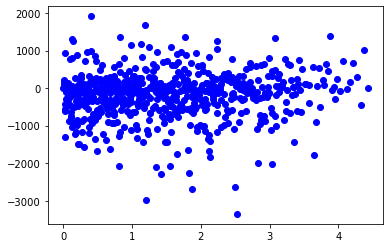

In [40]:
import matplotlib.pyplot as plt

 
plt.scatter(s, e, c ="blue")
 
# To show the plot
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression